# Selecting model points by cluster analysis

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lifelib-dev/clustering-model-points/HEAD?labpath=cluster_model_points_test2.ipynb)

This notebook applies cluster analysis to model point selection.
More specifically, we use the k-means method to partition a sample portfolio of seriatim policies and select representative model points.

As the sample portfolio, we use 10,000 seriatim term policies and their projection results, such as cashflows and the present values of the cashflows. The sample policies are generated by a jupyter notebook included in the ``cluster`` library. The model used for generating the cashflows and present values are derived from ``BasicTerm_ME`` in the `basiclife` library, and included in the ``cluster`` library.

There are many items to consider. For example,

* What is the target use case?
* What should we look at to see whether selected model points represent the sample portfolio good enough?
* What should we use for *local variables* ?
* What should the number of representative model points be?
* What initializataion method should we use for k-means?

**Target use case**

The target use case for this exercise is when we want to run deterministic projections of a large block of protection business under many different sensitivity scenarios. 

We construct a proxy portfolio based on the seriatim projection result of a base scenario by selecting and scaling representative polices. If the policy attributes of the proxy portfolio and projections results under the sensitivity scenarios obtained by using the proxy are close enough to those of the seriatim policies, then we can use the proxy portfolio of running the sensitivities and save time and computing resources.

In this exercise, we do not cover the cases where stochastic runs are involved. In reliaity, the stochastic cases would benefit more from the reduction in time and computing resources, so this topic will be discussed in future. 


**Target metrics**

To determine how closely selected policies represents the seriatim policies, we look at the following figures:

* Net cashflows
* Policy attributes, such as issue age, policy term, sum assured and duration. 
* Presnet value of net cashflows and their components.

Among the above, the most important metric would be the present value of net cashflows, as it often represents the whole or a major part of insurance liabilities. 
In practice, the maximum allowable error in the estimation of the present value of cashflows would be around 1%

**Choice of variables** 

The k-means method partitions samples based on squared Euclidean distances between samples. Samples are vectors of variable values.
What we choose for the variables has significant impact on the results. The chosen variables are more accurately estimated by the proxy portfolio. In this exercise, we test the following 3 types of variables and compare the results. 

* Net cashflows
* Policy attributes
* Present values of net cashflows and their components

Although not covered in this exercise, combinations of variables chosen across the 3 types above may yield better results. Further tests are left to subsequent studies.

**Reduction ratio**

Reduction ratio is defined as the number of seriatim policies devided by the number of selected representative model points.
The higher the ratio is, the more effective the proxy portfolio is. In this exercise, we select 1000 model points out of 10,000,
so the ratio in 10. The ratio and the accuracy of the proxy is a trade-off. Furthur tests beyond this exercise are desired to see how high the ratio we can get while maintaiing a certain level of accuracy. 


**Initialization method**

The k-means method returns diffrent outcomes depending on their initial values of cluster centroids. 
How to select the initial values is an area to be furthur explored, but in this exercise, we simply use the default method provided by sciki-learn.


*References:*

- [Gan, G. and Huang, J. (2017). A Data Mining Framework for Valuing Large Portfolios of Variable Annuities](http://library.usc.edu.ph/ACM/KKD%202017/pdfs/p1467.pdf)
- [Gan, G. and Valdez, E. A. (2019). Data Clustering with Actuarial Applications](https://deliverypdf.ssrn.com/delivery.php?ID=790086090127101095023064120110126117016083053010057028103075008126105105078103014074010017029060104024054109107072101085009103005023049082020120108076087100122100031019062051090024067099088106113090004110007127008101072121110098068079127127080025125064&EXT=pdf&INDEX=TRUE)
- [Goto, Y. A method to determine model points with cluster analysis, *Virtual ICA 2018*](https://www.actuview.com/video/A-method-to-determine-model-points-with-cluster-analysis/9084a36ba)
- [Milliman. Cluster analysis: A spatial approach to actuarial modeling](https://www.milliman.com/-/media/milliman/importedfiles/uploadedfiles/insight/research/life-rr/clusteranalysisaspatialrr080108pdf.ashx)


In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, r2_score
import matplotlib.cm 
import matplotlib.pyplot as plt

## Sample Data

3 types of data are used, which are policy data, cashflow data and present value data. The policy data is in one file, while each of the other two consists of 3 sets of files, which correspond to the base, lapse-stress, and mortality-stress scenarios. 

The base cashflows and present values are used for calibration, while the cashflows and present values of the stressed scenarios are not.

### Cashflow Data

3 sets of cashflow data are read from Excel files into DataFrames. The DataFrames are assigned to these 3 global variables:

* `cfs`: The base scenario
* `csf_lapse50`: The stress scenario of 50% level increase in lapse rates
* `cfs_mort15`: The stress scenario of 15% level increase in mortality rates

In each file, net annual cashflows of the 10,000 sample policies are included. 
The files are outputs of `net_cf_annual` in `BasicTerm_ME_for_Cluster`.

In [2]:
cfs = pd.read_excel('cashflows_seriatim_10K.xlsx', index_col=0)
cfs_lapse50 = pd.read_excel('cashflows_seriatim_10K_lapse50.xlsx', index_col=0)
cfs_mort15 = pd.read_excel('cashflows_seriatim_10K_mort15.xlsx', index_col=0)
cfs_list = [cfs, cfs_lapse50, cfs_mort15]

The chart below compares the shapes of the 3 aggregated cashflows.

<AxesSubplot:title={'center':'Cashflows'}>

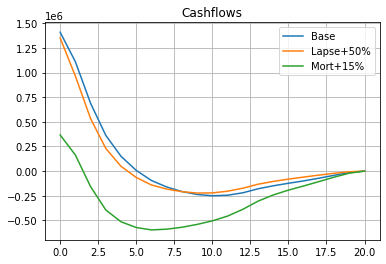

In [3]:
pd.DataFrame.from_dict({
    'Base': cfs.sum(), 
    'Lapse+50%': cfs_lapse50.sum(), 
    'Mort+15%': cfs_mort15.sum()}).plot(grid=True, title='Cashflows')

### Policy Data

Policy data is read from an Excel file into a DataFrame. In this sample case, 4 attributes completely defines a policy, so only the attributes are extracted as columns of the DataFrame. The DataFrame is then assigned to `pol_data`.  

In [4]:
pol_data = pd.read_excel(
    'BasicTerm_ME_for_Cluster/model_point_table.xlsx', index_col=0
)[['age_at_entry', 'policy_term', 'sum_assured', 'duration_mth']]
pol_data

,age_at_entry,policy_term,sum_assured,duration_mth
policy_id,,,,
1,47,10,622000,28
2,29,20,752000,214
3,51,10,799000,39
4,32,20,422000,140
5,28,15,605000,76
...,...,...,...,...
9996,47,20,827000,168
9997,30,15,826000,170
9998,45,20,783000,158


### Present Value Data

For each of the 3 scnarios, the present values of the net cashflowand their components are read from an Excel file into a DataFrame. The components are the present values of premiums, claims, expenses and commissions. The DataFrames are assigned to these 3 global variables:

* `pvs`: The base scenario
* `pvs_lapse50`: The stress scenario of 50% level increase in lapse rates
* `pvs_mort15`: The stress scenario of 15% level increase in mortality rates

In each file, net annual cashflows of the 10,000 sample policies are included. The files are outputs of `result_pv` in `BasicTerm_ME_for_Cluster`. The discount rate used is flat 3%.

In [5]:
pvs = pd.read_excel('pv_seriatim_10K.xlsx', index_col=0)
pvs_lapse50 = pd.read_excel('pv_seriatim_10K_lapse50.xlsx', index_col=0)
pvs_mort15 = pd.read_excel('pv_seriatim_10K_mort15.xlsx', index_col=0)
pvs_list = [pvs, pvs_lapse50, pvs_mort15]
pvs

,pv_premiums,pv_claims,pv_expenses,pv_commissions,pv_net_cf
policy_id,,,,,
1,5117.931213,3786.367310,278.536674,0.0,1053.027229
2,1508.426320,1677.981398,124.621416,0.0,-294.176494
3,8333.617576,6646.840127,270.360068,0.0,1416.417381
4,3229.275711,3098.020912,424.560625,0.0,-293.305825
5,3203.527395,2653.011845,401.855897,0.0,148.659654
...,...,...,...,...,...
9996,11839.037487,13872.879725,318.025035,0.0,-2351.867273
9997,603.175537,610.655414,49.244725,0.0,-56.724602
9998,10887.623809,12130.102842,356.697457,0.0,-1599.176490


## Python Code


`Clusters`, a class to facilitate the calibration process is defined below. 
The `Clusters` class wraps the fitted `KMeans` object which is calibrated using variables given as `loc_vars` through its initializer. 


We use the `KMeans` class imported from scikit-learn library in the initializer of the `Clusters` class.
The `fit` method on a `KMeans` object returns the object fitted using the local variables given to the method.

We use the `pairwise_distances_argmin_min` method from sckit-learn to find the samples closest to the centroids of the fitted `KMeans` object.

The `labels_` property of the fitted `KMeans` object holds cluster ID for each sample, indicating which cluster each sample belongs to.



In [6]:
class Clusters:
    
    def __init__(self, loc_vars):
        
        self.kmeans = kmeans = KMeans(n_clusters=1000, random_state=0).fit(np.ascontiguousarray(loc_vars))
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, np.ascontiguousarray(loc_vars))
        
        rep_ids = pd.Series(data=(closest+1))   # 0-based to 1-based indexes
        rep_ids.name = 'policy_id'
        rep_ids.index.name = 'cluster_id'
        self.rep_ids = rep_ids
        
        self.policy_count = self.agg_by_cluster(pd.DataFrame({'policy_count': [1] * len(loc_vars)}))['policy_count']

    def agg_by_cluster(self, df, agg=None):
        """Aggregate columns by cluster"""
        temp = df.copy()
        temp['cluster_id'] = self.kmeans.labels_
        temp = temp.set_index('cluster_id')
        agg = {c: (agg[c] if c in agg else 'sum') for c in temp.columns} if agg else sum
        return temp.groupby(temp.index).agg(agg)
    
    def extract_reps(self, df):
        """Extract the rows of representative policies"""
        temp = pd.merge(self.rep_ids, df.reset_index(), how='left', on='policy_id')
        temp.index.name = 'cluster_id'
        return temp.drop('policy_id', axis=1)
    
    def extract_and_scale_reps(self, df, agg=None):
        """Extract and scale the rows of representative policies"""
        if agg:
            cols = df.columns
            mult = pd.DataFrame({c: (self.policy_count if (c not in agg or agg[c] == 'sum') else 1) for c in cols})
            return self.extract_reps(df).mul(mult)
        else:
            return self.extract_reps(df).mul(self.policy_count, axis=0)
    
    def compare(self, df, agg=None):
        """Returns a multi-indexed Dataframe comparing actual and estimate"""
        source = self.agg_by_cluster(df, agg)
        target = self.extract_and_scale_reps(df, agg)
        return pd.DataFrame({'actual': source.stack(), 'estimate':target.stack()})
    
    def compare_total(self, df, agg=None):            
        """Aggregate ``df`` by columns"""
        if agg:
            cols = df.columns
            op = {c: (agg[c] if c in agg else 'sum') for c in df.columns}
            actual = df.agg(op)
            estimate = self.extract_and_scale_reps(df, agg=op)
            
            op = {k: ((lambda s: s.dot(self.policy_count) / self.policy_count.sum()) if v == 'mean' else v) for k, v in op.items()}
            estimate = estimate.agg(op)
                        
        else:
            actual = df.sum()
            estimate = self.extract_and_scale_reps(df).sum()

        return pd.DataFrame({'actual': actual, 'estimate': estimate, 'error': estimate / actual - 1})

The functions below are for outputting plots.

In [45]:
def generate_subplots(count, shape):
    "Generator to output multiple charts in subplots"
    
    row_count, col_count = shape
    size_x, size_y = plt.rcParams['figure.figsize']
    size_x, size_y = size_x * col_count, size_y * row_count
    
    fig, axs = plt.subplots(row_count, col_count, figsize=(size_x, size_y))
    fig.tight_layout(pad=3)
    
    for i in range(count):
        r = i // col_count
        c = i - r * col_count
        ax = axs[r, c] if (row_count > 1 and col_count > 1) else axs[r] if row_count > 1 else axs[c] if col_count > 1 else axs
        ax.grid(True)
        yield ax


def plot_colored_scatter(ax, df, title=None):
    """Draw a scatter plot in different colours by level-1 index
    
    ``df`` should be a DataFrame returned by the compare method.
    """

    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(df.index.levels[1])))

    for y, c in zip(df.index.levels[1], colors):
        ax.scatter(df.xs(y, level=1)['actual'], df.xs(y, level=1)['estimate'], color=c, s=9)

    ax.set_xlabel('actual')
    ax.set_ylabel('estimate')
    if title:
        ax.set_title(title)
    ax.grid(True)
    draw_identity_line(ax)


def plot_separate_scatter(df, row_count, col_count):
    """Draw multiple scatter plot with R-squared
    
    ``df`` should be a DataFrame returned by the compare method.
    """
    names = df.index.levels[1]
    count = len(names)

    size_x, size_y = plt.rcParams['figure.figsize']
    size_x, size_y = size_x * col_count, size_y * row_count
    
    for i, ax in enumerate(generate_subplots(count, (row_count, col_count))):
        df_n = df.xs(names[i], level=1)
        df_n.plot(x='actual', y='estimate', kind='scatter', ax=ax, title=names[i], grid=True)
        draw_identity_line(ax)
        
        # Add R2 in upper left corner
        r2_x = 0.95 * ax.get_xlim()[0] + 0.05 * ax.get_xlim()[1]
        r2_y = 0.05 * ax.get_ylim()[0] + 0.95 * ax.get_ylim()[1]
        ax.text(r2_x, r2_y, 'R2: {:.1f}%'.format(calc_r2_score(df_n) * 100), verticalalignment='top')

        
def draw_identity_line(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'r-', linewidth=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    
def calc_r2_score(df):
    "Return R-squared between actual and estimate columns"
    return r2_score(df['actual'], df['estimate'])


## Cashflow Calibration

The first calibration approach we test is to use base annual cashflows as calibration variables.

In [8]:
cluster_cfs = Clusters(cfs)

### Cashflow Analysis

Below the total net cashflows under the base scenario are compared between `actual`, which denotes the total net cashflows of the seriatim sample policies, 
and `estimate`, which denots the total net cashflows calculated as the net cashflows of the selected representative policies multiplied by the numbers of policies in the clusters.

In [9]:
cluster_cfs.compare_total(cfs)

,actual,estimate,error
0,1.409713e+06,1.405274e+06,-0.003149
1,1.110216e+06,1.105978e+06,-0.003818
2,6.877546e+05,6.844142e+05,-0.004857
3,3.621695e+05,3.593421e+05,-0.007807
4,1.498953e+05,1.583609e+05,0.056477
5,6.925899e+03,1.578994e+04,1.279840
6,-9.557953e+04,-8.971875e+04,-0.061318
7,-1.611534e+05,-1.590505e+05,-0.013049
8,-2.077423e+05,-1.990170e+05,-0.042001
9,-2.373941e+05,-2.299657e+05,-0.031291


The charts below visualize how well the estimated cashflows match the actual.

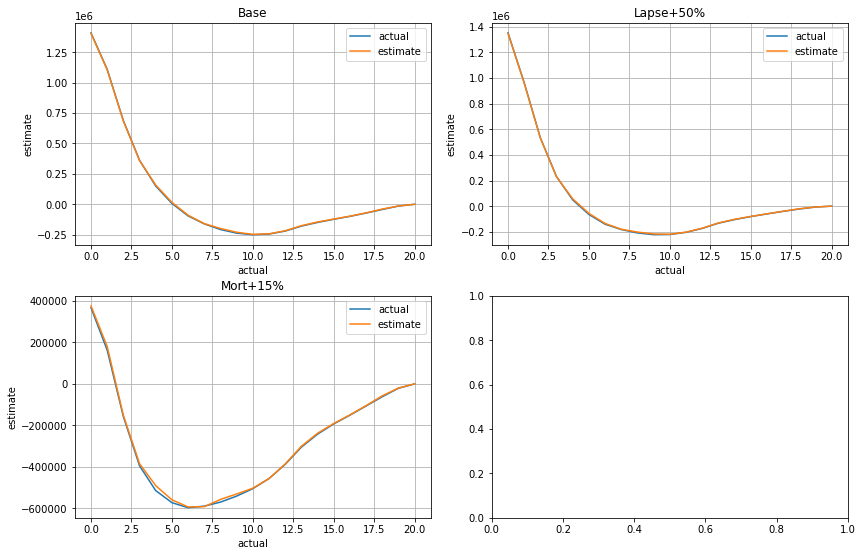

In [10]:
def plot_cashflows(ax, cfs, title=None):
    "Draw line plots of cashflows"
    cfs[['actual', 'estimate']].plot(ax= ax, grid=True, title=title, xlabel='actual', ylabel='estimate')

scen_titles = ['Base', 'Lapse+50%', 'Mort+15%']
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_cashflows(ax, cluster_cfs.compare_total(df), title)

The scatter charts below plots net annual cashflows by cluster. The read plots represent the nearest cashflows while violet plots are the farthest.

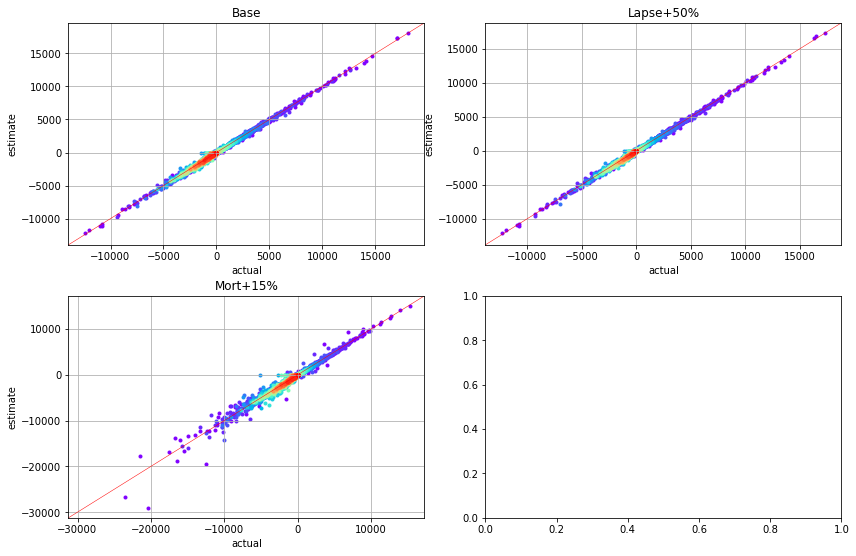

In [11]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_colored_scatter(ax, cluster_cfs.compare(df), title=title)

### Policy Attribute Analysis

In [18]:
mean_attrs = {'age_at_entry':'mean', 'policy_term':'mean', 'duration_mth':'mean'}
cluster_cfs.compare_total(pol_data, agg=mean_attrs)

,actual,estimate,error
age_at_entry,3.937720e+01,3.778780e+01,-0.040363
policy_term,1.493600e+01,1.492000e+01,-0.001071
sum_assured,5.060517e+09,5.195387e+09,0.026651
duration_mth,8.977800e+01,9.019030e+01,0.004592


The charts below visualize how well the estimated policy attributes match the actual. The `age_at_entry`, `policy_term` and `duration_mth` charts plot the average of them in each cluster, while the `sum_assured` chart plots the total of each cluster. 
The X axises represent the acutual values, while the Y axises represent the estimated values. 

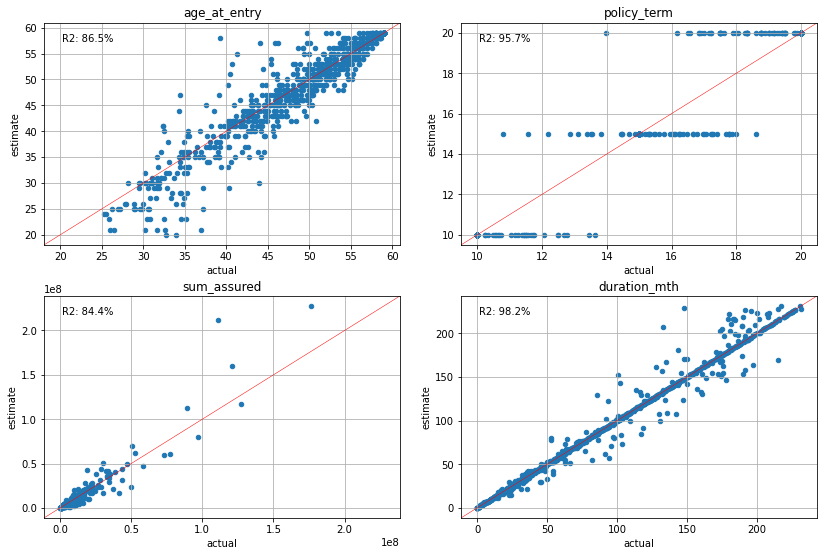

In [19]:
plot_separate_scatter(cluster_cfs.compare(pol_data, agg=mean_attrs), 2, 2)

### Present Value Analysis

The present values of the net cashflows and their components are estimated and compared against the seriatim results for each scenario.

In [12]:
cluster_cfs.compare_total(pvs)

,actual,estimate,error
pv_premiums,4.849091e+07,4.803716e+07,-0.009357
pv_claims,4.317444e+07,4.269227e+07,-0.011168
pv_expenses,2.952639e+06,2.953675e+06,0.000351
pv_commissions,2.966005e+05,2.881471e+05,-0.028501
pv_net_cf,2.067232e+06,2.103076e+06,0.017339


In [13]:
cluster_cfs.compare_total(pvs_lapse50)

,actual,estimate,error
pv_premiums,4.267459e+07,4.222926e+07,-0.010436
pv_claims,3.816769e+07,3.769687e+07,-0.012335
pv_expenses,2.581294e+06,2.585410e+06,0.001594
pv_commissions,2.857406e+05,2.776656e+05,-0.028260
pv_net_cf,1.639868e+06,1.669311e+06,0.017955


In [14]:
cluster_cfs.compare_total(pvs_mort15)

,actual,estimate,error
pv_premiums,4.841554e+07,4.796358e+07,-0.009335
pv_claims,4.956615e+07,4.901358e+07,-0.011148
pv_expenses,2.949730e+06,2.950982e+06,0.000424
pv_commissions,2.965904e+05,2.881376e+05,-0.028500
pv_net_cf,-4.396926e+06,-4.289122e+06,-0.024518


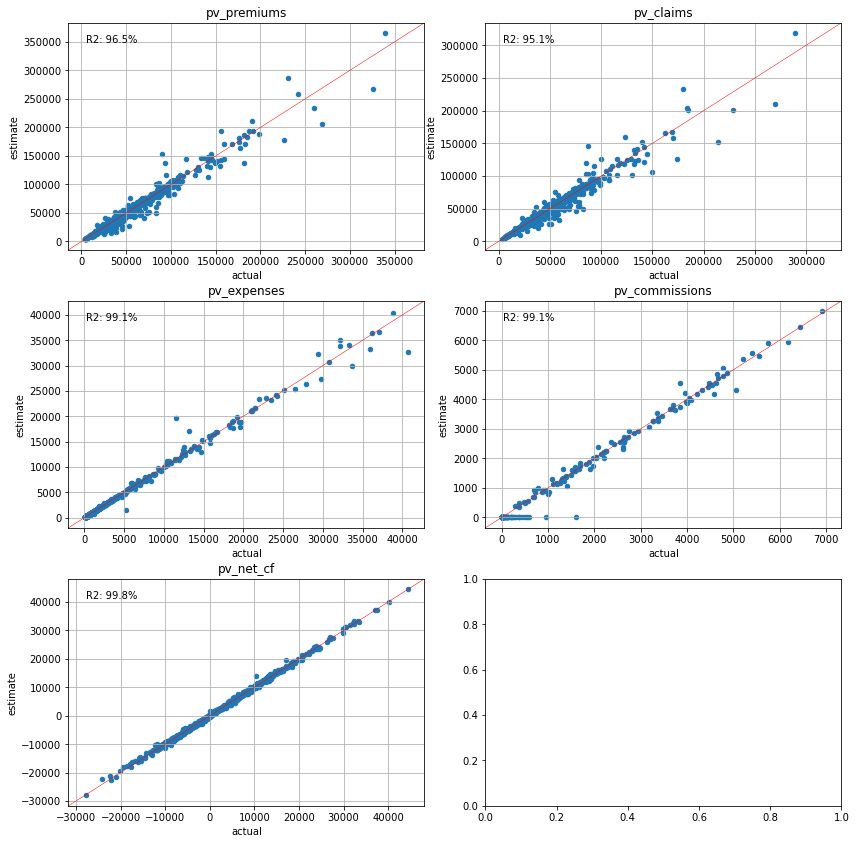

In [15]:
plot_separate_scatter(cluster_cfs.compare(pvs), 3, 2)

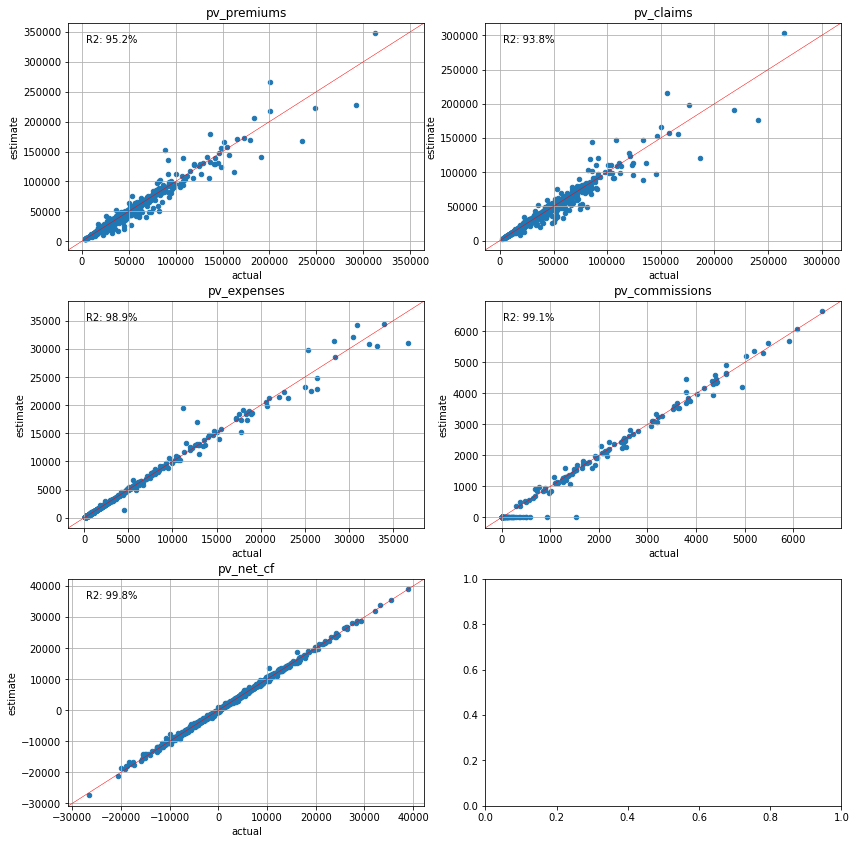

In [16]:
plot_separate_scatter(cluster_cfs.compare(pvs_lapse50), 3, 2)

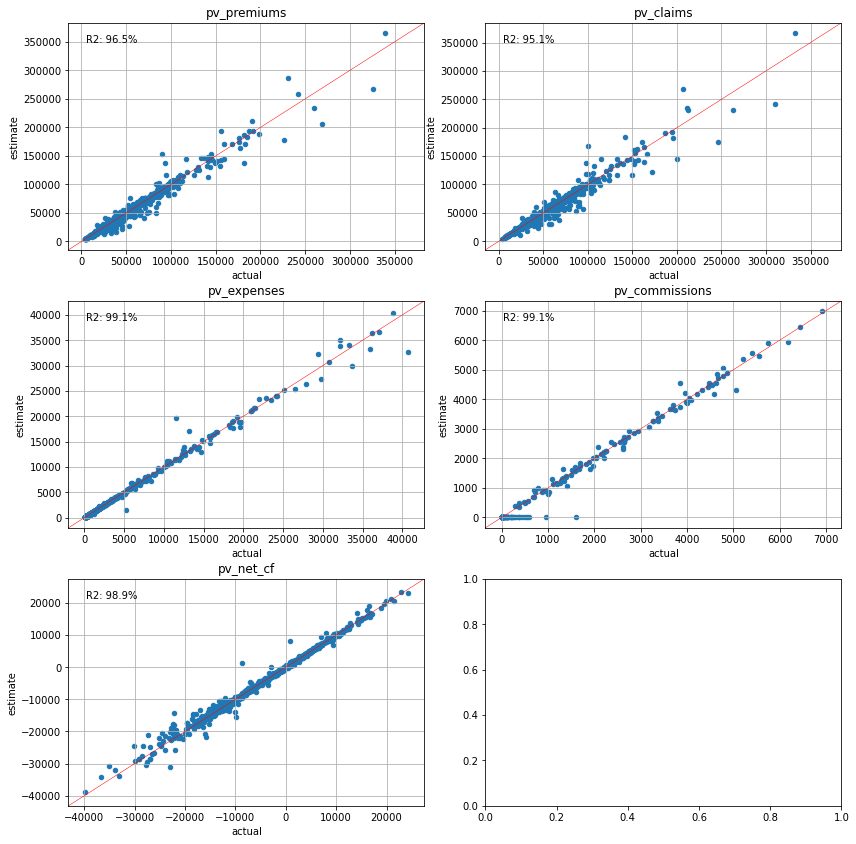

In [17]:
plot_separate_scatter(cluster_cfs.compare(pvs_mort15), 3, 2)

## Policy Attribute Calibration

The next pattern to examine using the pollicy attributes as local variables for k-means.


* [Effect of (not) standardizing variables in k-means clustering - Dmitrijs Kass' blog](https://dmitrijskass.netlify.app/2019/10/22/effect-of-not-standardizing-variables-in-k-means-clustering/)

In [20]:
loc_vars = (pol_data- pol_data.min()) / (pol_data.max()- pol_data.min())
loc_vars

,age_at_entry,policy_term,sum_assured,duration_mth
policy_id,,,,
1,0.692308,0.0,0.618182,0.116667
2,0.230769,1.0,0.749495,0.891667
3,0.794872,0.0,0.796970,0.162500
4,0.307692,1.0,0.416162,0.583333
5,0.205128,0.5,0.601010,0.316667
...,...,...,...,...
9996,0.692308,1.0,0.825253,0.700000
9997,0.256410,0.5,0.824242,0.708333
9998,0.641026,1.0,0.780808,0.658333


In [21]:
cluster_attrs = Clusters(loc_vars)

### Cashflow Analysis

In [22]:
cluster_attrs.compare_total(cfs)

,actual,estimate,error
0,1.409713e+06,1.483202e+06,0.052131
1,1.110216e+06,1.074104e+06,-0.032527
2,6.877546e+05,7.039497e+05,0.023548
3,3.621695e+05,3.728454e+05,0.029478
4,1.498953e+05,1.460572e+05,-0.025605
5,6.925899e+03,2.201014e+04,2.177947
6,-9.557953e+04,-7.803111e+04,-0.183600
7,-1.611534e+05,-1.613141e+05,0.000997
8,-2.077423e+05,-2.205822e+05,0.061807
9,-2.373941e+05,-2.321534e+05,-0.022076


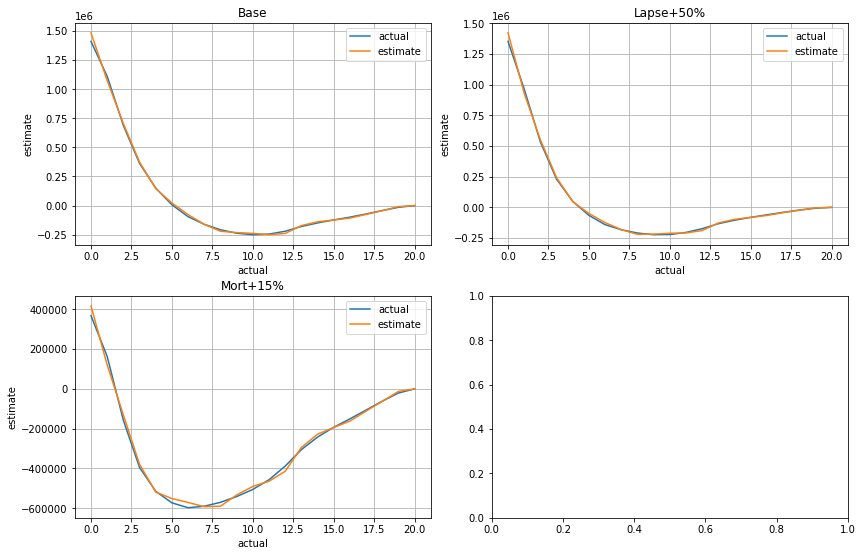

In [23]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_cashflows(ax, cluster_attrs.compare_total(df), title)

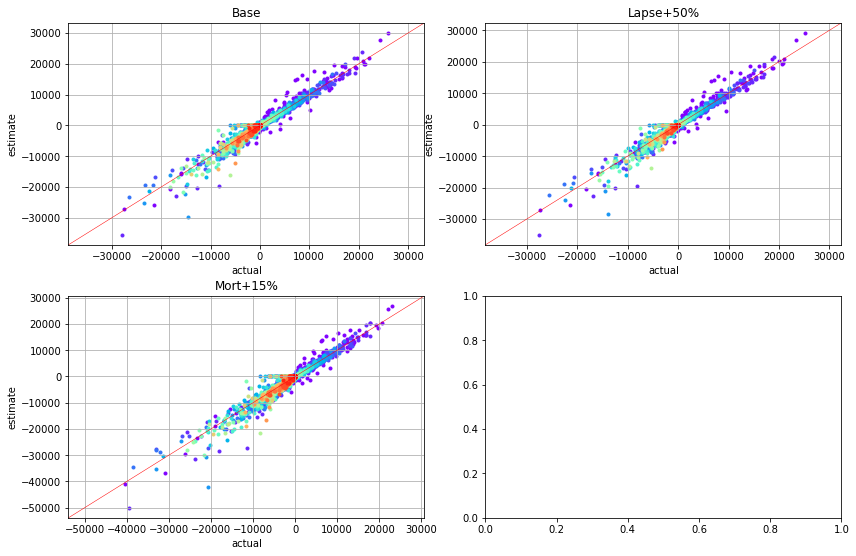

In [24]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_colored_scatter(ax, cluster_attrs.compare(df), title=title)

### Policy Attribute Analysis



In [25]:
cluster_attrs.compare_total(pol_data, agg=mean_attrs)

,actual,estimate,error
age_at_entry,3.937720e+01,3.938340e+01,0.000157
policy_term,1.493600e+01,1.493600e+01,0.000000
sum_assured,5.060517e+09,5.065294e+09,0.000944
duration_mth,8.977800e+01,8.977660e+01,-0.000016


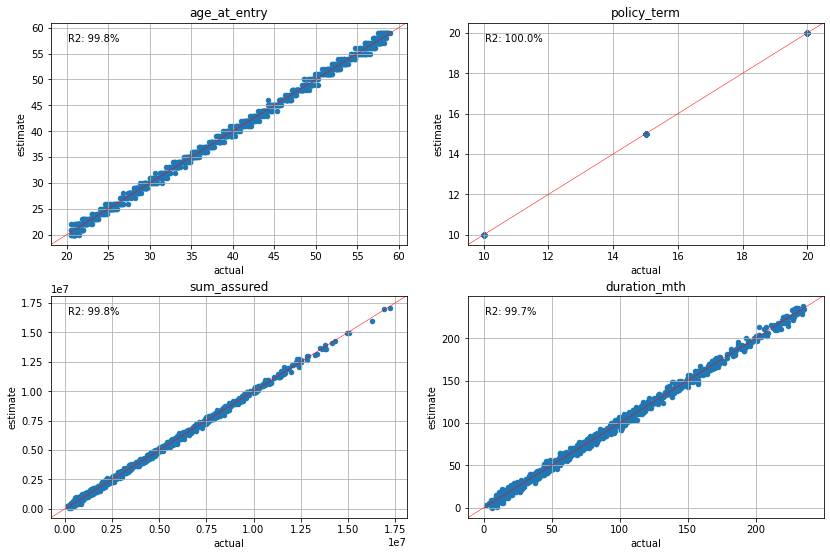

In [26]:
plot_separate_scatter(cluster_attrs.compare(pol_data, agg=mean_attrs), 2, 2)

### Present Value Analysis

In [27]:
cluster_attrs.compare_total(pvs)

,actual,estimate,error
pv_premiums,4.849091e+07,4.851637e+07,0.000525
pv_claims,4.317444e+07,4.322375e+07,0.001142
pv_expenses,2.952639e+06,2.955942e+06,0.001119
pv_commissions,2.966005e+05,1.909668e+05,-0.356148
pv_net_cf,2.067232e+06,2.145714e+06,0.037965


In [28]:
cluster_attrs.compare_total(pvs_lapse50)

,actual,estimate,error
pv_premiums,4.267459e+07,4.272028e+07,0.001071
pv_claims,3.816769e+07,3.822667e+07,0.001545
pv_expenses,2.581294e+06,2.585519e+06,0.001636
pv_commissions,2.857406e+05,1.854010e+05,-0.351156
pv_net_cf,1.639868e+06,1.722699e+06,0.050511


In [29]:
cluster_attrs.compare_total(pvs_mort15)

,actual,estimate,error
pv_premiums,4.841554e+07,4.844202e+07,0.000547
pv_claims,4.956615e+07,4.962421e+07,0.001172
pv_expenses,2.949730e+06,2.953039e+06,0.001122
pv_commissions,2.965904e+05,1.909616e+05,-0.356144
pv_net_cf,-4.396926e+06,-4.326199e+06,-0.016086


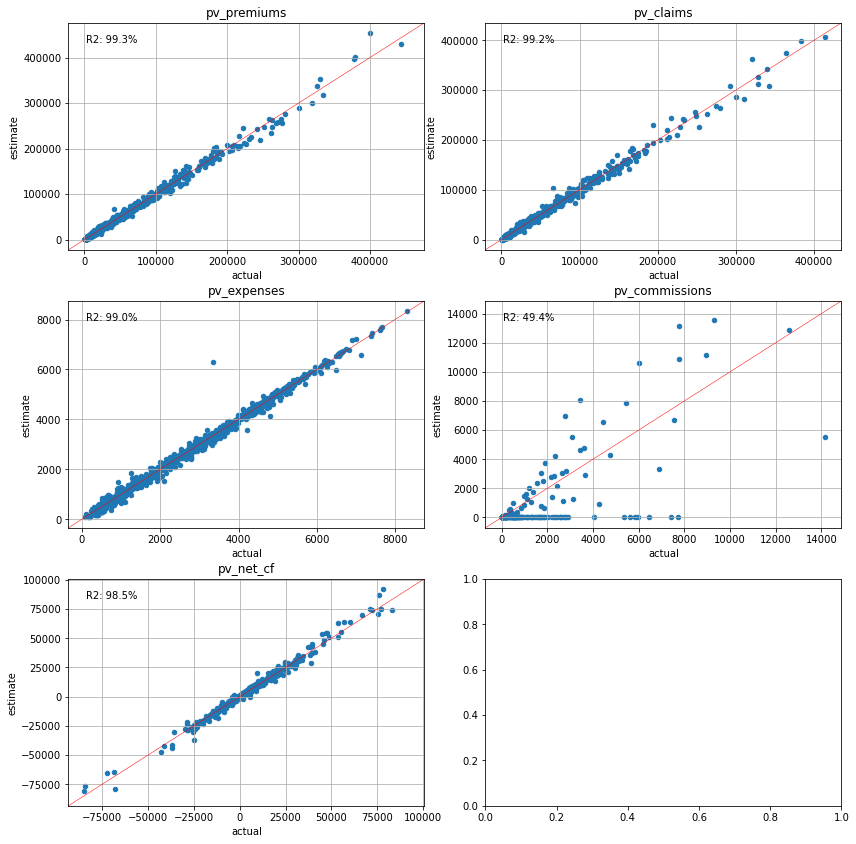

In [30]:
plot_separate_scatter(cluster_attrs.compare(pvs), 3, 2)

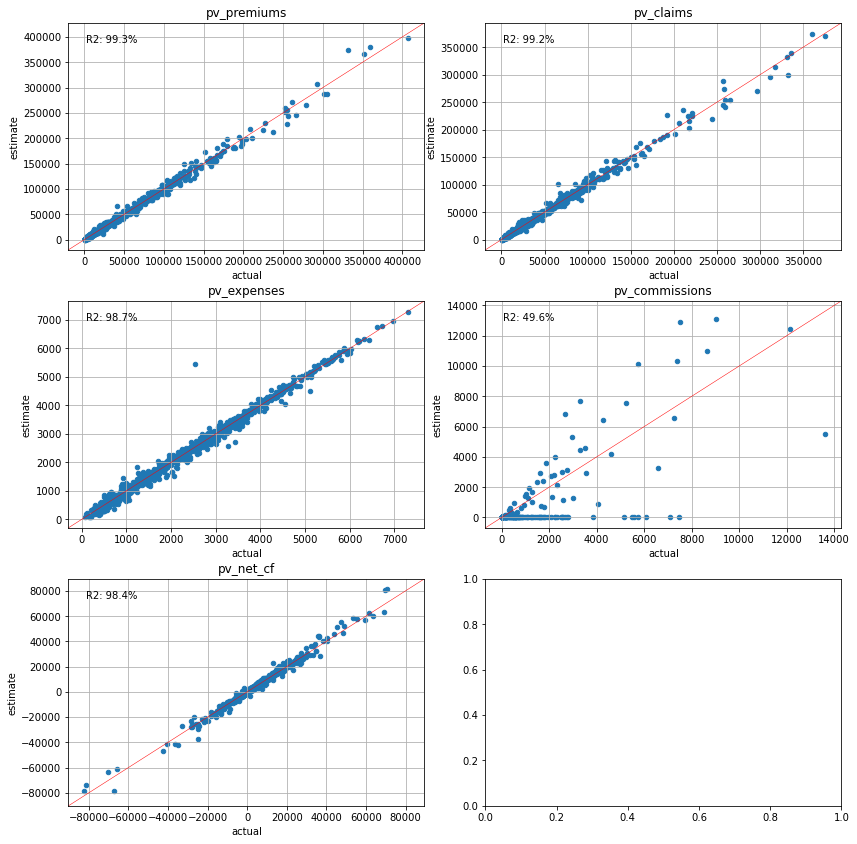

In [31]:
plot_separate_scatter(cluster_attrs.compare(pvs_lapse50), 3, 2)

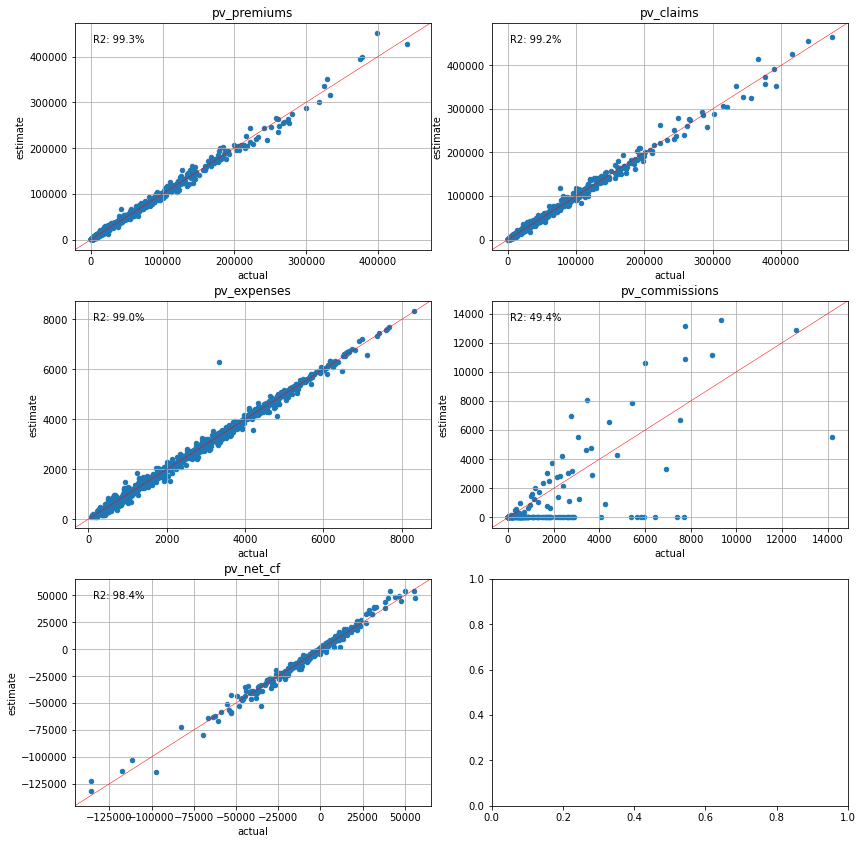

In [32]:
plot_separate_scatter(cluster_attrs.compare(pvs_mort15), 3, 2)

## Calibrating Present Values Calibration

In [33]:
cluster_pvs = Clusters(pvs)

### Cashflow Analysis

In [34]:
cluster_pvs.compare_total(cfs)

,actual,estimate,error
0,1.409713e+06,1.426387e+06,0.011828
1,1.110216e+06,1.088073e+06,-0.019946
2,6.877546e+05,6.870559e+05,-0.001016
3,3.621695e+05,3.562320e+05,-0.016394
4,1.498953e+05,1.570126e+05,0.047482
5,6.925899e+03,1.738389e+04,1.509983
6,-9.557953e+04,-7.913310e+04,-0.172071
7,-1.611534e+05,-1.653879e+05,0.026276
8,-2.077423e+05,-2.116182e+05,0.018657
9,-2.373941e+05,-2.544463e+05,0.071831


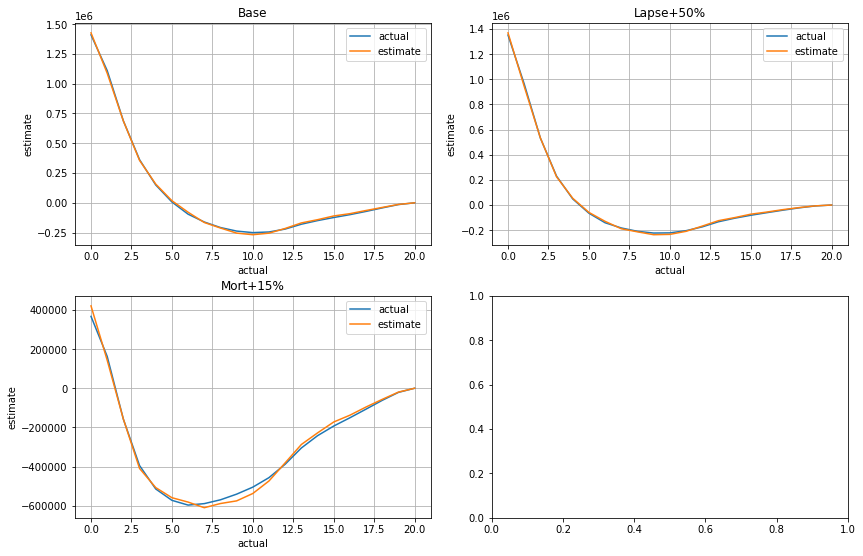

In [35]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_cashflows(ax, cluster_pvs.compare_total(df), title)

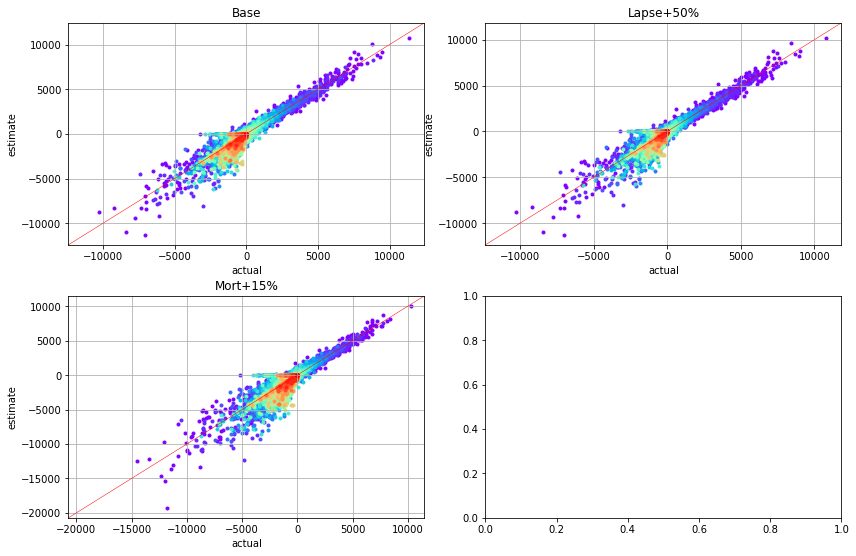

In [36]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_colored_scatter(ax, cluster_pvs.compare(df), title=title)

### Policy Attribute Analysis

In [37]:
cluster_pvs.compare_total(pol_data, agg=mean_attrs)

,actual,estimate,error
age_at_entry,3.937720e+01,3.965740e+01,0.007116
policy_term,1.493600e+01,1.480050e+01,-0.009072
sum_assured,5.060517e+09,4.862761e+09,-0.039078
duration_mth,8.977800e+01,8.939170e+01,-0.004303


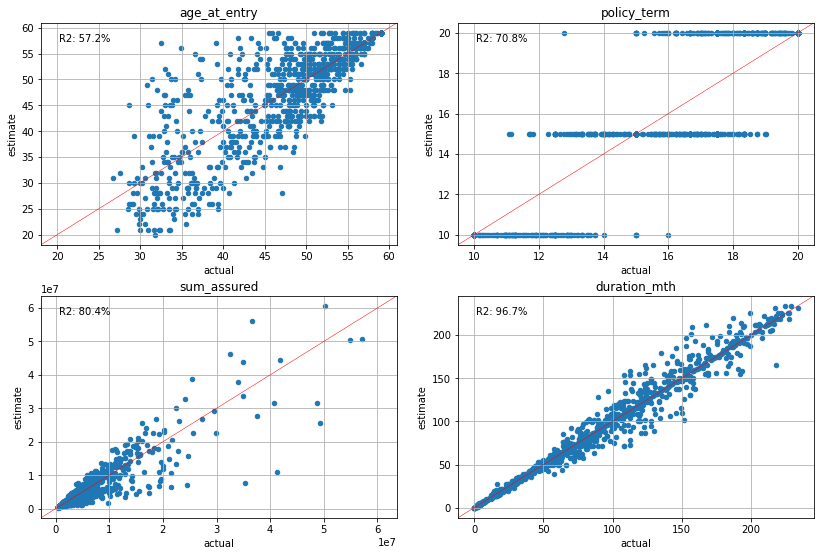

In [38]:
plot_separate_scatter(cluster_pvs.compare(pol_data, agg=mean_attrs), 2, 2)

### Present Value Analysis

In [39]:
cluster_pvs.compare_total(pvs)

,actual,estimate,error
pv_premiums,4.849091e+07,4.848840e+07,-0.000052
pv_claims,4.317444e+07,4.317516e+07,0.000017
pv_expenses,2.952639e+06,2.954226e+06,0.000538
pv_commissions,2.966005e+05,2.759775e+05,-0.069531
pv_net_cf,2.067232e+06,2.083033e+06,0.007644


In [40]:
cluster_pvs.compare_total(pvs_lapse50)

,actual,estimate,error
pv_premiums,4.267459e+07,4.265378e+07,-0.000488
pv_claims,3.816769e+07,3.814752e+07,-0.000528
pv_expenses,2.581294e+06,2.591520e+06,0.003962
pv_commissions,2.857406e+05,2.657141e+05,-0.070086
pv_net_cf,1.639868e+06,1.649022e+06,0.005582


In [41]:
cluster_pvs.compare_total(pvs_mort15)

,actual,estimate,error
pv_premiums,4.841554e+07,4.841267e+07,-0.000059
pv_claims,4.956615e+07,4.956651e+07,0.000007
pv_expenses,2.949730e+06,2.951361e+06,0.000553
pv_commissions,2.965904e+05,2.759676e+05,-0.069533
pv_net_cf,-4.396926e+06,-4.381168e+06,-0.003584


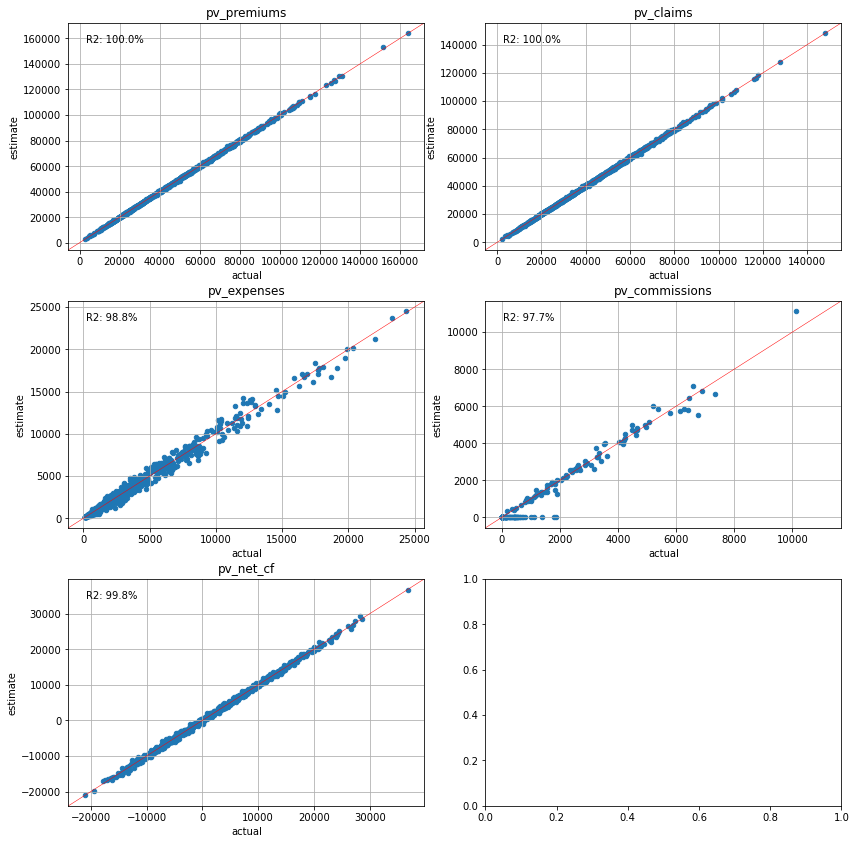

In [42]:
plot_separate_scatter(cluster_pvs.compare(pvs), 3, 2)

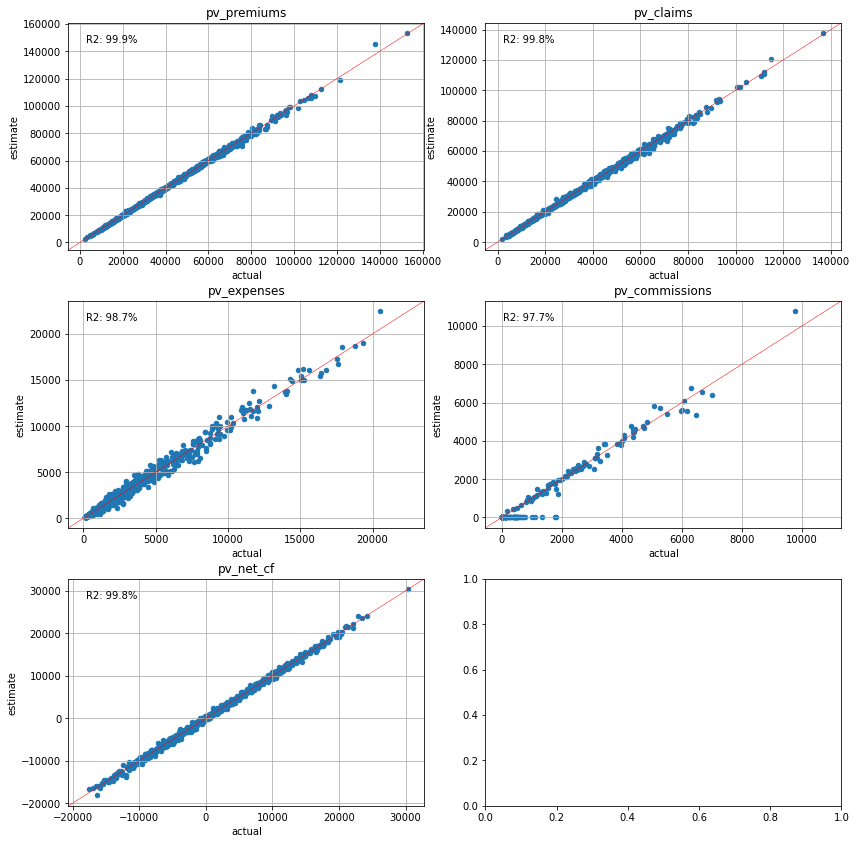

In [43]:
plot_separate_scatter(cluster_pvs.compare(pvs_lapse50), 3, 2)

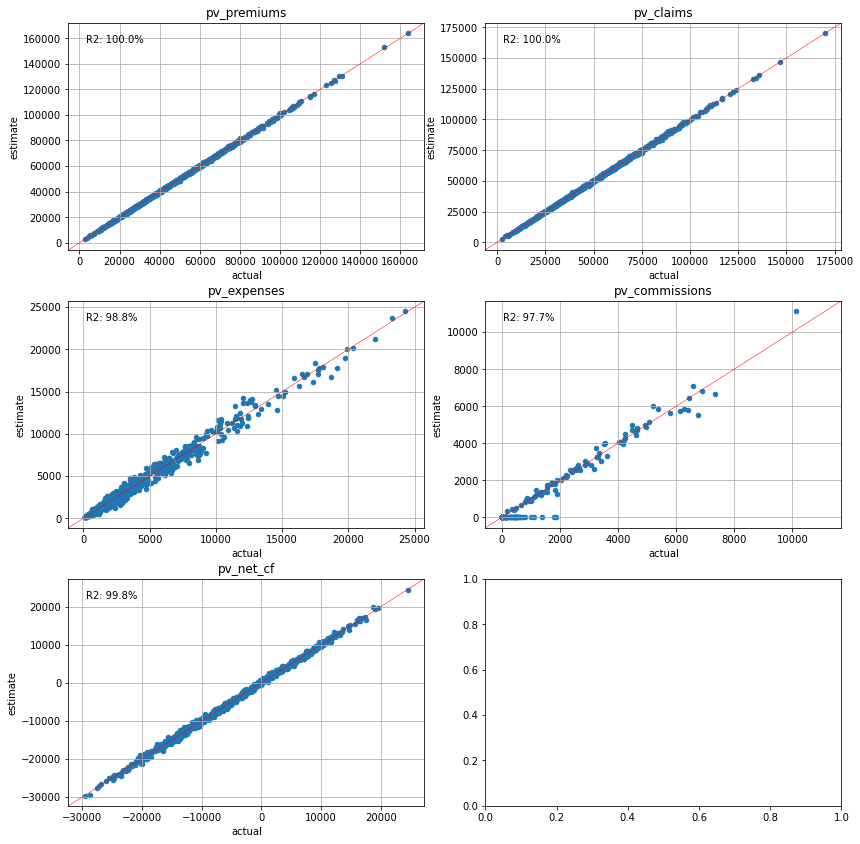

In [44]:
plot_separate_scatter(cluster_pvs.compare(pvs_mort15), 3, 2)

## Conclustion

As expected, the results are highly dependent on the choice of calibration variables. The variables chosen for calibration are more accurately estimated by the proxy portfolio than others. In practice, the present values of cashflows are are often the most important metrics. Our exercise shows that the present values of net cashflows are reprecated well enogh, with error percentages below 1% in all the scenarios.